# Obiettivi del Progetto:
1. **Strategie di Augmentation**: Implementare diverse tecniche di augmentation per
arricchire il dataset, migliorando la variabilità e la qualità dei dati.
2. **Divisione del Dataset**: Suddividere il dataset in trainset, valset e testset per garantire
un'adeguata formazione e validazione del modello.
3. **Architetture di Rete e Transfer Learning**: Selezionare e implementare una o più architetture di rete neurale adatte al problema, utilizzando il transfer learning per sfruttare modelli pre-addestrati.
4. *Fine Tuning e Scelta degli Hyperparameters*: Creare un classificatore personalizzato,
scegliere gli hyperparameters e ottimizzare il modello attraverso processi di training e
validation.
5. **Validation e Regolarizzazione**: Utilizzare tecniche di validation per migliorare la scelta
degli hyperparameters e risolvere potenziali problemi con tecniche di regolarizzazione.
6. **Test Finale**: Eseguire un test finale per verificare le capacità di generalizzazione del
modello e raggiungere le performance desiderate.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
import os
import random

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import confusion_matrix
import seaborn as sns
import json

In [ ]:
do_train = False # Variabile che, quando è true, effettua l'addestramento; quando è false, carica i risultati precedenti SENZA riaddestrare

## 1. Seed di Riproducibilità + passaggio sulla GPU

In [ ]:
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(0)

In [ ]:
# Solito passaggio alla GPU:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd "/gdrive/My Drive/Colab Notebooks/Progetto/"

/gdrive/My Drive/Colab Notebooks/Progetto


## 2. Carico Dataset

Il dataset è formato da 14000 immagini appartenenti a 14 classi, e soprattutto già splittato in train, validation e test set:
- 8960 immagini nel train;
- 2240 immagini nel val;
- 2800 immagini nel test
- RGB con dimensione di 512 x 512
- Inoltre, le classi sono bilanciate

Prima di andare effettivamente a costruire una suite per l'augmentation, vado innanzitutto a vedere che immagini ci sono all'interno del trainset, applicando una prima semplicissima trasformazione:

In [ ]:
# Creo innanzittutto la classica classe Transforms:
class Transforms:
  def __init__(self, transforms):
    self.transforms = transforms
  def __call__(self, img, *args, **kwargs):
    return self.transforms(image=np.array(img))['image']

In [ ]:
# E adesso la prima trasformazione molto semplice:
transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

OSS: mentre svolgo questo compito, sto anche seguendo il corso di Computer Vision, e ho imparato che la normalizzazione da applicare il più delle volte è quella che ho applicato nella cella!

In [ ]:
# Carico ora tutti i set, applicando la trasformazione:
trainset = torchvision.datasets.ImageFolder(root='dataset/train', transform = Transforms(transform))
testset = torchvision.datasets.ImageFolder(root='dataset/test', transform = Transforms(transform))
valset = torchvision.datasets.ImageFolder(root='dataset/val', transform = Transforms(transform))

In [ ]:
# Check shape e valori normalizzati:
trainset[0][0].shape

torch.Size([3, 256, 256])

In [ ]:
# Check grandezza:
print(f"Elementi nel train set:", len(trainset))
print(f"Elementi nel test set:", len(testset))
print(f"Elementi nel validation set:", len(valset))

Elementi nel train set: 8960
Elementi nel test set: 2800
Elementi nel validation set: 2240


In [ ]:
# Funzione per convertire un'immagine DA tensore A formato visualizzabile:
def back_to_image(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0)) # Altezza, Larghezza, Canali

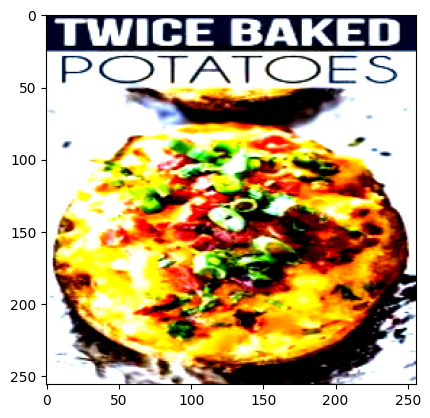

In [ ]:
# Proviamo ad applicare questa funzione stampando un'immagine del dataset:
image = back_to_image(trainset[1][0])
plt.imshow(image)
plt.show()

In [ ]:
# Visualizziamo ora un set di immagini del trainset:
classes = trainset.classes
classes

['Baked Potato',
 'Crispy Chicken',
 'Donut',
 'Fries',
 'Hot Dog',
 'Sandwich',
 'Taco',
 'Taquito',
 'apple_pie',
 'cheesecake',
 'chicken_curry',
 'ice_cream',
 'omelette',
 'sushi']

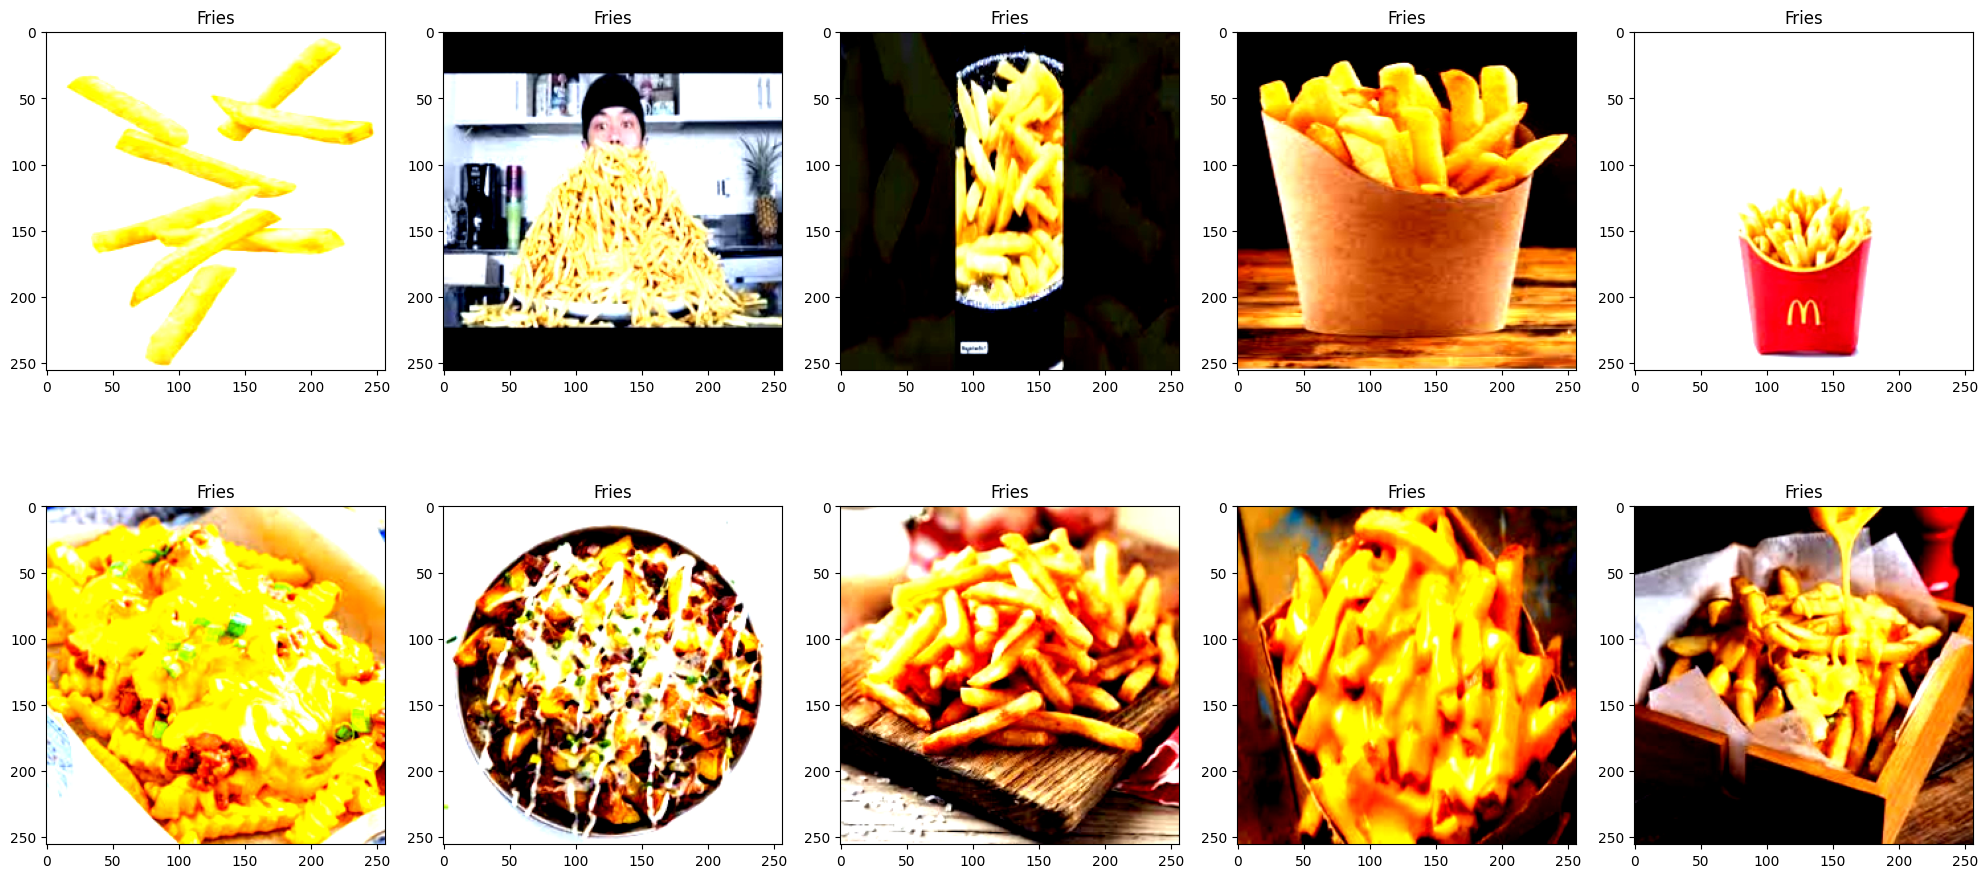

In [ ]:
iteration = 200

# Setto gli indici della riga e della colonna:
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(back_to_image(trainset[iteration * num_row * num_col + i][0]))
    ax.set_title('{}'.format(classes[int(trainset[iteration * num_row * num_col + i][1])]))
plt.tight_layout()
plt.show()
iteration += 1

### 2.1 Augmentation

Per testare correttamente + augmentation fino a trovare quella giusta, la mia strategia si basa sull'andare a:
- definire la trasformazione;
- applicarla a tutto il trainset e valset;
- visualizzare le immagini e vedere se il cibo comunque resta riconoscibile.

Per semplicità (e soprattutto perché non ho ottenuto risultati soddisfacenti nelle passate prove), definisco 2 trasformazioni DISTINTE per il train e per il val set.

In [ ]:
# Riduco la dimensione a 256 x 256, applico una random crop di 224x224 (in quanto userò ResNet per il TL, e conviene mettere queste dimensioni per il training) la normalzizazione e converto in tensore:
# OSS: per il validation, invece, ho notato che è meglio applicare una CenterCrop.

train_transform = A.Compose([
    A.Resize(256, 256),
    A.RandomCrop(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(),
    A.Transpose(),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [ ]:
# Ricarichiamo ora il dataset applicando al nuova trasformazione:
trainset = torchvision.datasets.ImageFolder(root='dataset/train', transform = Transforms(train_transform))
valset = torchvision.datasets.ImageFolder(root='dataset/val', transform = Transforms(val_transform))

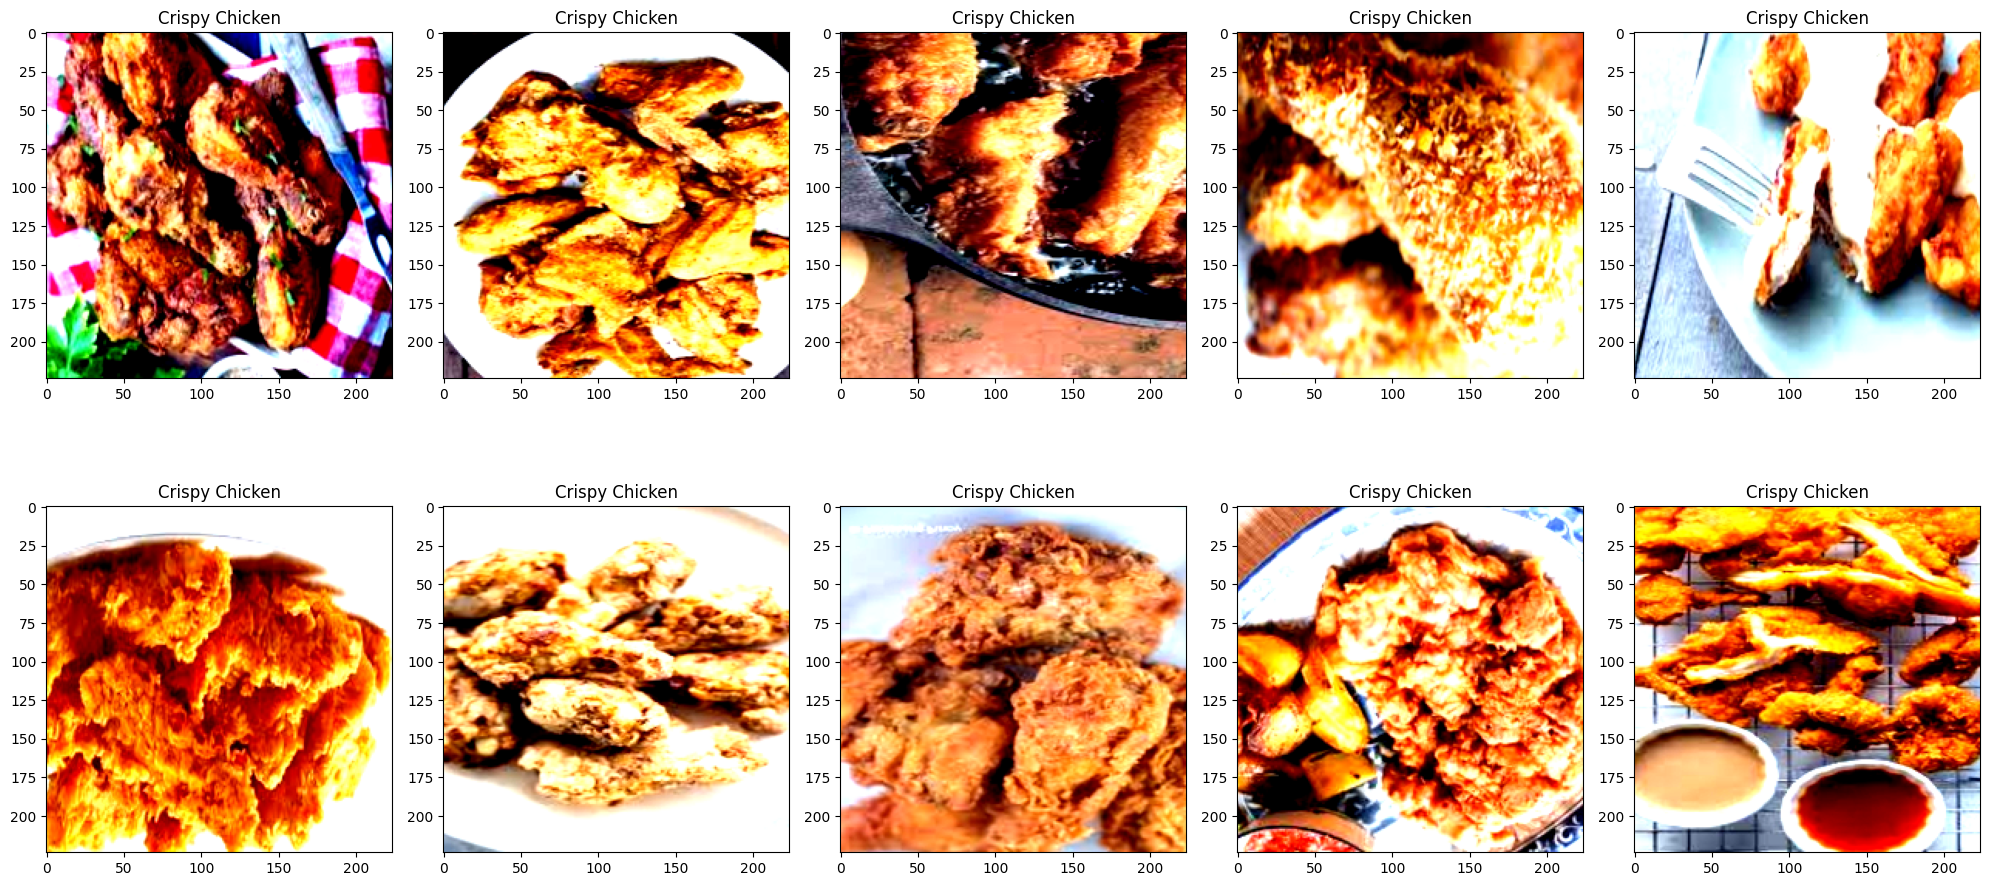

In [ ]:
iteration = 100

# Setto gli indici della riga e della colonna:
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(back_to_image(trainset[iteration * num_row * num_col + i][0]))
    ax.set_title('{}'.format(classes[int(trainset[iteration * num_row * num_col + i][1])]))
plt.tight_layout()
plt.show()
iteration += 1

### 2.2 Definisco le solite funzioni di supporto

#### Classe unica per tutti gli esperimenti

Visto che andrò a creare un po' di modelli facendo anche tuning degli iperparametri, definisco questa classe (in modo da evitare codice ridondante):

In [ ]:
from dataclasses import dataclass, field


@dataclass
class Experiment:
  "Questa classe rappresenta tutti gli iperparametri e il modello di ogni esperimento"
  name: str
  #checkpoints_folder: str
  #checkpoint_name: str
  model: object
  use_early_stopping: bool
  criterion: object
  optimizer: object
  #color:str
  #alpha:float
  #Aggiungiamo il safe_path anche per il checkpoint:
  checkpoint_save_path: str = None
  val_mse: float = None

  lr: float = 1e-5
  epochs: int = 600
  patience: int = 5
  min_delta: float = 0

  # Aggiungo poi ovviamente le 3 liste di risultati restituite dal training:
  train_loss_values: list = field(default_factory=list)
  test_loss_values: list = field(default_factory=list)
  test_accuracies_values: list = field(default_factory=list)

  plt_args_training: dict = field(default_factory=dict)
  plt_args_validation: dict = field(default_factory=dict)


  # Metodo che inizializza il model (già però istanziato) e l'optimizer
  def __post_init__(self):
    self.optimizer = self.optimizer(params=self.model.parameters(), lr=self.lr)

In [ ]:
# Solite funzioni per il training e il testing:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    processed_data = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        processed_data += len(inputs)

    return running_loss / processed_data



def test_epoch(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

#### Funzione EarlyStopping

In [ ]:
class EarlyStopping:
  def __init__(self, save_path, patience=5, min_delta=0):
    self.save_path = save_path
    self.patience = patience
    self.min_delta = min_delta
    self.min_val_loss = None
    self.counter = 0
    self.early_stop = False


  def __call__(self, validation_loss, model):

    if self.min_val_loss is None: # Prima Epoca
      self.min_val_loss = validation_loss
      self.save_checkpoint(model)

    elif (self.min_val_loss - validation_loss) > self.min_delta: # Epoca di miglioramento
      self.min_val_loss = validation_loss
      self.save_checkpoint(model)
      self.counter = 0


    else: # Nessun miglioramento
      self.counter += 1
      if self.counter >= self.patience:
        self.early_stop = True


  def save_checkpoint(self, model):
    torch.save(model.state_dict(), self.save_path)

#### Funzione per il train completo

Chiama ovviamente la funzione per allenare una singola epoca in un loop; leggermente riscritta in virtù della classe "Experiment".

In [ ]:
def train(exp: Experiment, train_loader, test_loader, device):
    model = exp.model.to(device)
    criterion = exp.criterion
    optimizer = exp.optimizer
    epochs = exp.epochs

    train_losses = []
    test_losses = []
    test_accuracies = []

    # Early stopping (solo se attivo)
    early_stopping = None
    if exp.use_early_stopping:
        early_stopping = EarlyStopping(
            save_path=exp.checkpoint_save_path,
            patience=exp.patience,
            min_delta=exp.min_delta
        )

    for epoch in range(epochs):
        # Calcolo quindi le metriche di addestramento
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_accuracy = test_epoch(model, test_loader, criterion, device)


        # Le salvo:
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Stampo:
        print(f"[{exp.name}] Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {test_loss:.4f} | "
              f"Val Acc: {test_accuracy:.4f}")

        # Check dell'early stopping
        if early_stopping is not None:
            early_stopping(test_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break


    # Salvo le metriche nell’oggetto
    exp.train_loss_values = train_losses
    exp.test_loss_values = test_losses
    exp.test_accuracies_values = test_accuracies


    return exp

#### Funzione per il testing finale di un esperimento

In [ ]:
def test_experiment(exp: Experiment, test_loader, device):
    model = exp.model.to(device)
    criterion = exp.criterion

    # Uso la funzione già esistente
    test_loss, test_accuracy = test_epoch(model, test_loader, criterion, device)

    # Salvo le metriche dentro l’oggetto per tracciarle anche dopo
    exp.val_mse = test_loss
    exp.test_accuracies_values.append(test_accuracy)

    print(f"[{exp.name}] Accuracy sul test set: {test_accuracy:.4f}, "
          f"Loss: {test_loss:.4f}")

    return test_loss, test_accuracy

In [ ]:
def plot_confusion_matrix(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)

            # Vediamo le predictions per l'accuracy
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')

Dovendo allenare molti modelli per fare hyperparameters tuning, definisco un'unica classe fatta in questo modo:

In [ ]:
# Creo un array in cui andare a memorizzare tutti gli esperimenti, per poi iterarci sopra quando farò il training:
experiments = []

#### Caricamento dei set nei dataloader + batch_size

In [ ]:
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True) # Passo già il trainset augmentato
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

---------

# 3. DEFINIZIONE DELLE RETI

🚨 FONDAMENTALE: Il parametro su cui faccio tuning è il learning rate, provando prima con 1e-4 e poi con 1e-3.

## 3.1 - MODELLO 1: BASELINE

Inizio col creare un modello molto semplice, giusto per vedere come si comporta la rete senza fare alcun transfer learning o tuning particolare.

In [ ]:
class Baseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)     #Params 5*5*3 = 75 + 1 = 76 * 6 = 456
        self.pool = nn.MaxPool2d(2)         #Params 0
        self.conv2 = nn.Conv2d(6, 16, 5)    #Params 5*5*6 = 150 + 1 = 151 * 16 = 2416


        self.fc1 = nn.Linear(16 * 61 * 61, 120)    #Params 59536 + 1 = 59537 * 120 = 7 144 440
        self.fc2 = nn.Linear(120, 84)       #Params 120 + 1 = 121 * 84 = 10 164
        self.fc3 = nn.Linear(84, 14)        #Params 84 + 1 = 85 * 14 = 1190

    def forward(self, x): #Input [128,3,256,256]
        x = self.conv1(x) #Output [128,6,252,252]
        x = F.relu(x)
        x = self.pool(x)  #Output [128,6,126,126]

        x = self.conv2(x) #Output [128,16,122,122]
        x = F.relu(x)
        x = self.pool(x)  #Output [128,16,61,61]

        x = torch.flatten(x, 1) # flatten su tutte le dimensioni [128, 16*61*61] = [128, 59 536]

        x = self.fc1(x)  #Output [128,120]
        x = F.relu(x)
        x = self.fc2(x)  #Output [128,84]
        x = F.relu(x)
        x = self.fc3(x)  #Output [128,14]

        return x

In [ ]:
baseline = Baseline().to(device)

In [ ]:
summary(baseline, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 252, 252]             456
         MaxPool2d-2          [-1, 6, 126, 126]               0
            Conv2d-3         [-1, 16, 122, 122]           2,416
         MaxPool2d-4           [-1, 16, 61, 61]               0
            Linear-5                  [-1, 120]       7,144,440
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 14]           1,190
Total params: 7,158,666
Trainable params: 7,158,666
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 5.91
Params size (MB): 27.31
Estimated Total Size (MB): 33.96
----------------------------------------------------------------


Mi vado anche a creare il percorso in cui salvare i risultati del training quando lo farò più avanti.

OSS: preferisco gestire manualmente la definizione dei percorsi di ogni modello, anche se potrei definire nella classe "Experiment" degli attributi per evitare codice ridondante, ma è una scelta che faccio per non confondermi troppo.

In [ ]:
baseline_path = "models/baseline/"
os.makedirs(baseline_path, exist_ok=True)
baseline_save_file = os.path.join(baseline_path, "baseline.pt")
baseline_save_log = os.path.join(baseline_path, "log.json")

In [ ]:
# Vado quindi a creare l'esperimento, e lo salvo poi nella lista:
baseline_exp = Experiment(
    name="baseline",
    model=baseline,
    use_early_stopping=True,
    criterion=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    lr = 1e-4,
    epochs = 50,
    patience = 5,
    min_delta = 0,
    checkpoint_save_path = baseline_save_file
)

experiments.append(baseline_exp)

In [ ]:
# Training:
if do_train:
    baseline = train(baseline_exp, trainloader, valloader, device)
    # Salvo poi i risultati costruendo prima il dict apposito usando direttamente i campi dell'experiment:
    to_save_json = {
        "name": baseline_exp.name,
        "train_losses": baseline_exp.train_loss_values,
        "test_losses": baseline_exp.test_loss_values,
        "test_accuracies": baseline_exp.test_accuracies_values,
        "val_mse": baseline_exp.val_mse,
        "lr": baseline_exp.lr,
        "epochs": baseline_exp.epochs,
        "patience": baseline_exp.patience,
        "min_delta": baseline_exp.min_delta
    }
    with open(baseline_save_log, 'w') as f:
      json.dump(to_save_json, f)

[baseline] Epoch 1/50 | Train Loss: 0.0200 | Val Loss: 0.0197 | Val Acc: 0.1973
[baseline] Epoch 2/50 | Train Loss: 0.0189 | Val Loss: 0.0190 | Val Acc: 0.1893
[baseline] Epoch 3/50 | Train Loss: 0.0182 | Val Loss: 0.0186 | Val Acc: 0.2085
[baseline] Epoch 4/50 | Train Loss: 0.0179 | Val Loss: 0.0183 | Val Acc: 0.2174
[baseline] Epoch 5/50 | Train Loss: 0.0176 | Val Loss: 0.0180 | Val Acc: 0.2469
[baseline] Epoch 6/50 | Train Loss: 0.0173 | Val Loss: 0.0181 | Val Acc: 0.2379
[baseline] Epoch 7/50 | Train Loss: 0.0171 | Val Loss: 0.0179 | Val Acc: 0.2616
[baseline] Epoch 8/50 | Train Loss: 0.0170 | Val Loss: 0.0176 | Val Acc: 0.2487
[baseline] Epoch 9/50 | Train Loss: 0.0169 | Val Loss: 0.0179 | Val Acc: 0.2469
[baseline] Epoch 10/50 | Train Loss: 0.0168 | Val Loss: 0.0173 | Val Acc: 0.2674
[baseline] Epoch 11/50 | Train Loss: 0.0167 | Val Loss: 0.0175 | Val Acc: 0.2656
[baseline] Epoch 12/50 | Train Loss: 0.0166 | Val Loss: 0.0172 | Val Acc: 0.2701
[baseline] Epoch 13/50 | Train Loss: 

In [ ]:
# Ricarico dunque i risulati del modello addestrato (pesi + log di addestramento, ovvero accuracy e loss)
baseline.model.load_state_dict(torch.load(baseline_save_file))# Apro
with open(baseline_save_log, "r") as f:
    baseline_log = json.load(f)

In [ ]:
# Valuto le metriche:
if do_train:
    val_loss, val_accuracy = test_experiment(baseline_exp, valloader, device)
else:
    val_loss = baseline_exp.test_loss_values[-1]
    val_accuracy = baseline_exp.test_accuracies_values[-1]

print(f"Accuracy sul validation set: {val_accuracy:.4f}")

[baseline] Accuracy sul test set: 0.3254, Loss: 0.0161
Accuracy sul validation set: 0.3254


Qualcosa il modello riesce a classificare correttamente, segno che comunque qualcosa riesce ad imparare. Ovviamente, non è un accuracy soddisfacente, quindi posso procedere a fare il transfer learning.

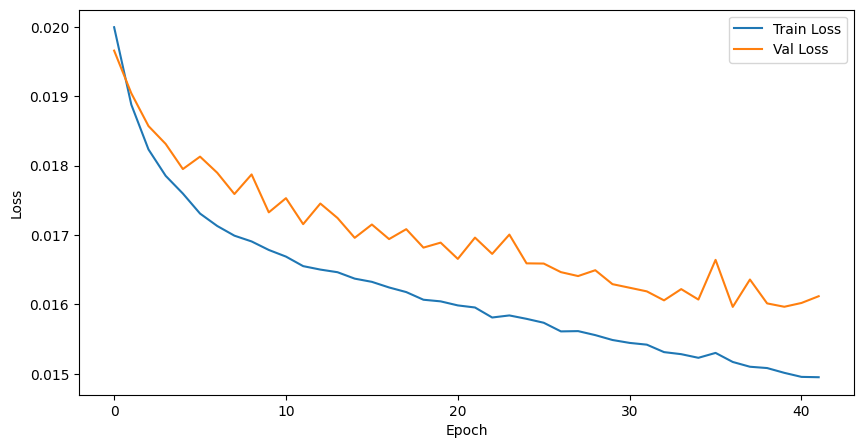

In [ ]:
# Plotto la loss:
plt.figure(figsize=(10,5))
plt.plot(baseline_log['train_losses'], label='Train Loss')
plt.plot(baseline_log['test_losses'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Anche qui si nota chiaramente che la loss sul validation set fino alla 25esima epoca circa scende, però poi è chiaro come tende ad overfittare.

## 3.2 - MODELLO 2: TRANSFER LEARNING

Per il transfer learning scelgo la ResNet50, andando a freezare i paramtri della backbone:

In [ ]:
# Importo quindi modello e pesi:
from torchvision.models import resnet50, ResNet50_Weights

In [ ]:
# Scarico quindi il modello:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


Aggiungo ora i miei layer fully connected. Per la precisione, uso:
- 2 layer lineari strutturati in questo modo: 2048 -> 512 -> 14 (invece che saltare direttamente da 2048 a 14); questo perché l'aggiunta di un layer intermedio consente di imparare rappresentazioni anche più complesse del cibo (evitando quindi overfiting e underfitting).

- 2 dropout: uno da 0.5 per prevenire overfitting sulle feature estratte dalla backbone della ResNet e uno a 0.3 più leggero poiché i 512 neuroni devono riuscire ad imparare pattern utili.

- ReLu: sempre utile mettere una fonte di non linearità

In [ ]:
# Come detto, vado quindi a congelare i parametri della backbone:
for param in model.parameters():
    param.requires_grad = False


# Attacco i miei layer:
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 14)
).to(device)

In [ ]:
resnet_save_folder = "models/resnet"
os.makedirs(resnet_save_folder, exist_ok=True)
resnet_save_file = os.path.join(resnet_save_folder, "resnet.pt")
resnet_save_log = os.path.join(resnet_save_folder, "log.json")

OSS: in un primissimo training che avevo fatto (sempre su 50 epoche), l'`early stopping` non era scattato (finendo per trainare per tutte e 50 le epoche...). Pertanto, ho optato per cambiare leggermente il `min_delta`: infatti, un miglioramento c'è solo se il validation loss diminuisce di più di min_delta. Tuttavia, a partire dalla seconda/teza epoca il miglioramento effettivo era veramente molto piccolo (circa 0.0001), e anche se la loss migliora solo leggermente, la differenza (min_val_loss - validation_loss) potrebbe non superare 0 per via dell’arrotondamento numerico e del rumore.

Pertanto, ho impostato adesso il min_delta leggermente > 0 --> 1e-4 per la precisione.

🚨 ATTENZIONE: avendo esaurito dopo il training della baseline lo spazio a disposizione sulla GPU, il seguente training l'ho fatto su un altro account, e pertanto adesso importo i risulati.

In [ ]:
from google.colab import files
uploaded = files.upload()  # carico i file .pt e .json dell'esperimento fatto sull'altro colab

Saving log.json to log.json
Saving resnet.pt to resnet.pt


In [ ]:
tf_exp = Experiment(
    name="resnet50",
    model=model,
    use_early_stopping=True,
    criterion=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    checkpoint_save_path=resnet_save_file,
    lr=1e-4,
    epochs = 50,
    patience = 5,
    min_delta = 1e-4
)

experiments.append(tf_exp)

In [ ]:
# Training:
if do_train:
    model = train(tf_exp, trainloader, valloader, device)
    # Salvo poi i risultati costruendo prima il dict apposito usando direttamente i campi dell'experiment:
    to_save_json = {
        "name": tf_exp.name,
        "train_losses": tf_exp.train_loss_values,
        "test_losses": tf_exp.test_loss_values,
        "test_accuracies": tf_exp.test_accuracies_values,
        "val_mse": tf_exp.val_mse,
        "lr": tf_exp.lr,
        "epochs": tf_exp.epochs,
        "patience": tf_exp.patience,
        "min_delta": tf_exp.min_delta
    }
    with open(resnet_save_log, 'w') as f:
      json.dump(to_save_json, f)

Stavolta l'early stopping è scattato, segno che il cambio del min_delta ha sicuramente funzionato. Inoltre, già da questi primissimi dati posso notare che l'`accuracy` si ferma sull'83%, che è un risultato ottimo e sicuramente migliore rispetto alla baseline (probabilmente, aumentando il numero di `epoche`, ottengo anzi un valore anche superiore).


Per completezza, riporto (tramite copia / incoll) i risulati del training:
</br>
[resnet50] Epoch 1/50 | Train Loss: 0.0192 | Val Loss: 0.0172 | Val Acc: 0.6728 </br>
[resnet50] Epoch 2/50 | Train Loss: 0.0148 | Val Loss: 0.0125 | Val Acc: 0.7067 </br>
[resnet50] Epoch 3/50 | Train Loss: 0.0114 | Val Loss: 0.0099 | Val Acc: 0.7384
</br>
[resnet50] Epoch 4/50 | Train Loss: 0.0097 | Val Loss: 0.0083 | Val Acc: 0.7549
</br>
[resnet50] Epoch 5/50 | Train Loss: 0.0086 | Val Loss: 0.0074 | Val Acc: 0.7732
</br>
[resnet50] Epoch 6/50 | Train Loss: 0.0079 | Val Loss: 0.0067 | Val Acc: 0.7839
</br>
[resnet50] Epoch 7/50 | Train Loss: 0.0074 | Val Loss: 0.0062 | Val Acc: 0.7978
</br>
[resnet50] Epoch 8/50 | Train Loss: 0.0070 | Val Loss: 0.0059 | Val Acc: 0.7973
</br>
[resnet50] Epoch 9/50 | Train Loss: 0.0067 | Val Loss: 0.0057 | Val Acc: 0.8049
</br>
[resnet50] Epoch 10/50 | Train Loss: 0.0065 | Val Loss: 0.0054 | Val Acc: 0.8094
</br>
[resnet50] Epoch 11/50 | Train Loss: 0.0062 | Val Loss: 0.0052 | Val Acc: 0.8098
</br>
[resnet50] Epoch 12/50 | Train Loss: 0.0062 | Val Loss: 0.0051 | Val Acc: 0.8138
</br>
[resnet50] Epoch 13/50 | Train Loss: 0.0061 | Val Loss: 0.0049 | Val Acc: 0.8196
</br>
[resnet50] Epoch 14/50 | Train Loss: 0.0059 | Val Loss: 0.0049 | Val Acc: 0.8161
</br>
[resnet50] Epoch 15/50 | Train Loss: 0.0058 | Val Loss: 0.0048 | Val Acc: 0.8214
</br>
[resnet50] Epoch 16/50 | Train Loss: 0.0057 | Val Loss: 0.0047 | Val Acc: 0.8161
</br>
[resnet50] Epoch 17/50 | Train Loss: 0.0055 | Val Loss: 0.0046 | Val Acc: 0.8205
</br>
[resnet50] Epoch 18/50 | Train Loss: 0.0056 | Val Loss: 0.0045 | Val Acc: 0.8254
</br>
[resnet50] Epoch 19/50 | Train Loss: 0.0055 | Val Loss: 0.0045 | Val Acc: 0.8223
</br>
[resnet50] Epoch 20/50 | Train Loss: 0.0054 | Val Loss: 0.0044 | Val Acc: 0.8263
</br>
[resnet50] Epoch 21/50 | Train Loss: 0.0054 | Val Loss: 0.0044 | Val Acc: 0.8277
</br>
[resnet50] Epoch 22/50 | Train Loss: 0.0052 | Val Loss: 0.0043 | Val Acc: 0.8272
</br>
[resnet50] Epoch 23/50 | Train Loss: 0.0052 | Val Loss: 0.0043 | Val Acc: 0.8286
</br>
[resnet50] Epoch 24/50 | Train Loss: 0.0052 | Val Loss: 0.0043 | Val Acc: 0.8290
</br>
[resnet50] Epoch 25/50 | Train Loss: 0.0052 | Val Loss: 0.0043 | Val Acc: 0.8321
</br>
[resnet50] Epoch 26/50 | Train Loss: 0.0051 | Val Loss: 0.0042 | Val Acc: 0.8304
</br>
[resnet50] Epoch 27/50 | Train Loss: 0.0050 | Val Loss: 0.0042 | Val Acc: 0.8304
</br>
[resnet50] Epoch 28/50 | Train Loss: 0.0051 | Val Loss: 0.0042 | Val Acc: 0.8304
</br>
[resnet50] Epoch 29/50 | Train Loss: 0.0050 | Val Loss: 0.0041 | Val Acc: 0.8375
</br>
[resnet50] Epoch 30/50 | Train Loss: 0.0049 | Val Loss: 0.0042 | Val Acc: 0.8308
</br>
[resnet50] Epoch 31/50 | Train Loss: 0.0049 | Val Loss: 0.0041 | Val Acc: 0.8344
</br>
[resnet50] Epoch 32/50 | Train Loss: 0.0049 | Val Loss: 0.0041 | Val Acc: 0.8353
</br>
[resnet50] Epoch 33/50 | Train Loss: 0.0048 | Val Loss: 0.0041 | Val Acc: 0.8362
</br>
[resnet50] Epoch 34/50 | Train Loss: 0.0049 | Val Loss: 0.0041 | Val Acc: 0.8330
</br>
Early stopping

Come dicevo, i risultati sono molto migliori rispetto alla baseline, con la train_loss che scende fino a 0.0047, la val_loss a 0.0041 e soprattutto un accuracy migliore, che raggiunge quasi l'84% (ottimo considerando i parametri freezati della backbone della resnet, e che soprattutto abbiamo 14 classi).

Quindi posso dire che:
- il modello sta imparando in modo consistente senza divergere;
- non ci sono segni seri di overfitting (che comunque adesso vado a verificare plottando i risultati).

In [ ]:
# Avendo caricato i file .pt e .json, lo script per caricarli qui l'ho dovuto leggermente modificare per evitare errori (rispetto a quello visto dal professore)

import io

tf_exp.model.load_state_dict(torch.load(io.BytesIO(uploaded['resnet.pt']))) # Carico i pesi dall'upload
resnet_log = json.loads(uploaded['log.json'].decode('utf-8')) # carico il log dall'upload

""" tf_exp.model.load_state_dict(torch.load(resnet_save_file))
with open(resnet_save_log, "r") as f:
    resnet_log = json.load(f) """

' tf_exp.model.load_state_dict(torch.load(resnet_save_file))\nwith open(resnet_save_log, "r") as f:\n    resnet_log = json.load(f) '

In [ ]:
# Valuto le metriche:
if do_train:
    val_loss, val_accuracy = test_experiment(tf_exp, valloader, device)
else:
    val_loss = resnet_log['test_losses'][-1]
    val_accuracy = resnet_log['test_accuracies'][-1]

print(f"Accuracy sul validation set: {val_accuracy:.4f}")

Accuracy sul validation set: 0.8330


Nettissimo il miglioramento sul validation set, con un accuracy che ora è all'83%, confermando dunque quanto detto prima.

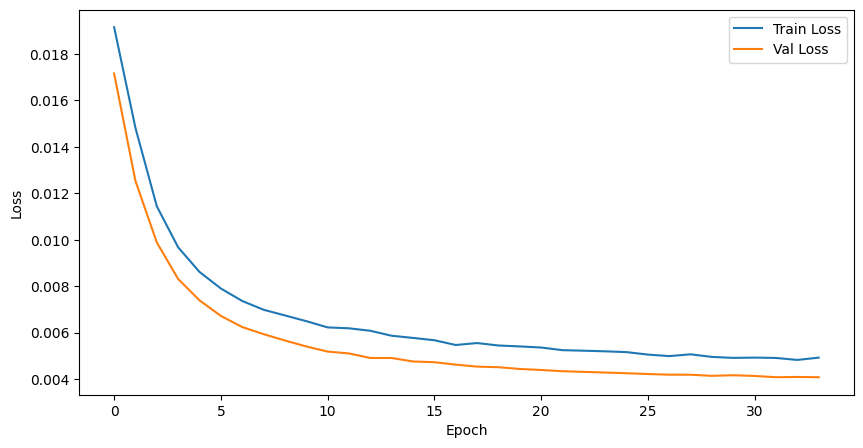

In [ ]:
# Plotto la loss:
plt.figure(figsize=(10,5))
plt.plot(resnet_log['train_losses'], label='Train Loss')
plt.plot(resnet_log['test_losses'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## 3.3 - MODELLO 3: TRANSFER LEARNING MA CON LEARNING RATE DIVERSO

Come detto precedentemente, provo ora a fare un po' di tuning sul learning rate, mettendolo a 1e-3; in questo modo, il modello dovrebbe convergere prima.

In [ ]:
resnet_save_folder = "models/resnet2"
os.makedirs(resnet_save_folder, exist_ok=True)
resnet_save_file = os.path.join(resnet_save_folder, "resnet2.pt")
resnet_save_log = os.path.join(resnet_save_folder, "log2.json")

In [ ]:
tf_exp2 = Experiment(
    name="resnet50_2",
    model=model,
    use_early_stopping=True,
    criterion=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    checkpoint_save_path=resnet_save_file,
    lr=1e-3,
    epochs = 50,
    patience = 5,
    min_delta = 0
)

experiments.append(tf_exp2)

In [ ]:
# Training:
if do_train:
    model = train(tf_exp2, trainloader, valloader, device)
    # Salvo poi i risultati costruendo prima il dict apposito usando direttamente i campi dell'experiment:
    to_save_json = {
        "name": tf_exp2.name,
        "train_losses": tf_exp2.train_loss_values,
        "test_losses": tf_exp2.test_loss_values,
        "test_accuracies": tf_exp2.test_accuracies_values,
        "val_mse": tf_exp2.val_mse,
        "lr": tf_exp2.lr,
        "epochs": tf_exp2.epochs,
        "patience": tf_exp2.patience,
        "min_delta": tf_exp2.min_delta
    }
    with open(resnet_save_log, 'w') as f:
      json.dump(to_save_json, f)

[resnet50_2] Epoch 1/50 | Train Loss: 0.0111 | Val Loss: 0.0060 | Val Acc: 0.7795
[resnet50_2] Epoch 2/50 | Train Loss: 0.0067 | Val Loss: 0.0050 | Val Acc: 0.8040
[resnet50_2] Epoch 3/50 | Train Loss: 0.0060 | Val Loss: 0.0046 | Val Acc: 0.8107
[resnet50_2] Epoch 4/50 | Train Loss: 0.0057 | Val Loss: 0.0044 | Val Acc: 0.8223
[resnet50_2] Epoch 5/50 | Train Loss: 0.0056 | Val Loss: 0.0043 | Val Acc: 0.8286
[resnet50_2] Epoch 6/50 | Train Loss: 0.0054 | Val Loss: 0.0043 | Val Acc: 0.8263
[resnet50_2] Epoch 7/50 | Train Loss: 0.0051 | Val Loss: 0.0041 | Val Acc: 0.8321
[resnet50_2] Epoch 8/50 | Train Loss: 0.0050 | Val Loss: 0.0040 | Val Acc: 0.8357
[resnet50_2] Epoch 9/50 | Train Loss: 0.0050 | Val Loss: 0.0040 | Val Acc: 0.8362
[resnet50_2] Epoch 10/50 | Train Loss: 0.0048 | Val Loss: 0.0040 | Val Acc: 0.8277
[resnet50_2] Epoch 11/50 | Train Loss: 0.0047 | Val Loss: 0.0038 | Val Acc: 0.8411
[resnet50_2] Epoch 12/50 | Train Loss: 0.0047 | Val Loss: 0.0039 | Val Acc: 0.8420
[resnet50_2] 

Già da qui si nota che l'accuracy è aumentata (seppur di poco) rispetto al modello con lr = 1e-4, assestandosi attorno al 84%. Anche la validation loss molto meglio: seegno che comunque il modello converge più velocemente e più in alto

In [ ]:
# Ricarico dunque i risulati del modello addestrato (pesi + log di addestramento, ovvero accuracy e loss)
tf_exp2.model.load_state_dict(torch.load(resnet_save_file)) # Carico i pesi
with open(resnet_save_log, "r") as f: # Carico i log salvati
    resnet_log = json.load(f)

In [ ]:
# Valuto le metriche:
if do_train:
    val_loss, val_accuracy = test_experiment(tf_exp2, valloader, device)
else:
    val_loss = tf_exp2.test_loss_values[-1]
    val_accuracy = tf_exp2.test_accuracies_values[-1]

print(f"Accuracy sul validation set: {val_accuracy:.4f}")

[resnet50_2] Accuracy sul test set: 0.8411, Loss: 0.0038
Accuracy sul validation set: 0.8411


Aumentata leggermente l'accuracy anche sul set di validation, passando dall'83% che avevamo ottenuto con il lr = 1e-4 all'84%.

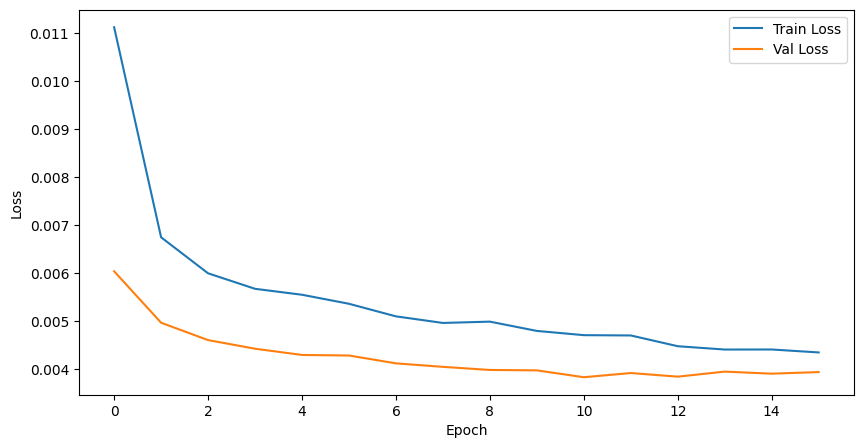

In [ ]:
# Plotto la loss:
plt.figure(figsize=(10,5))
plt.plot(resnet_log['train_losses'], label='Train Loss')
plt.plot(resnet_log['test_losses'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

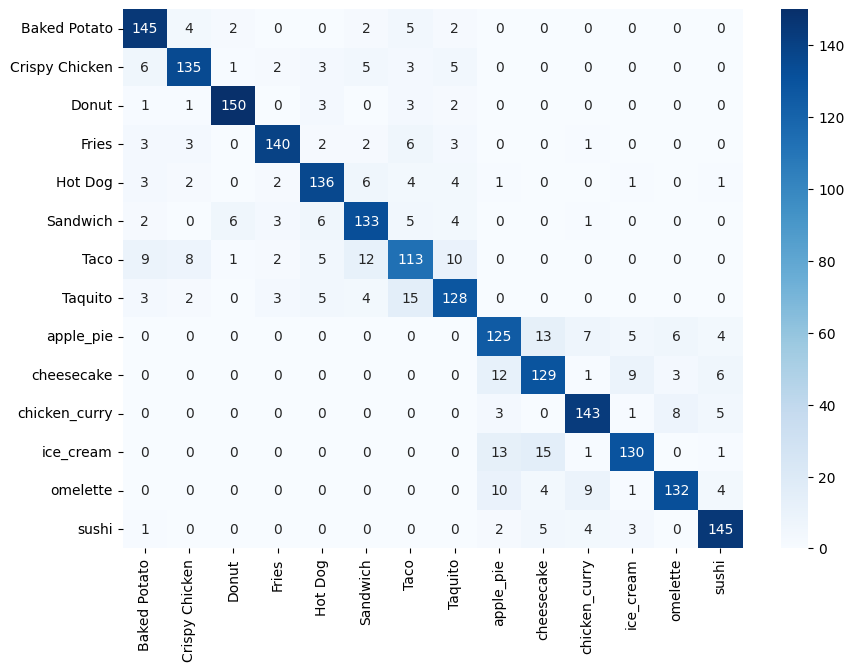

In [ ]:
# Essendo questo il modello migliore ottenuto fino ad ora, provo a stampare anche la confusion matrix:
plot_confusion_matrix(tf_exp2.model, valloader, device)

La diagonale che otteniamo è ottima, con molte classi che hanno valori molto alti (segno che comunque abbiamo un'alta accuracy per, ad esempio, Donut, Baked Potato ecc.).
C'è qualche "falso positivo" (come ad Baked Potato vs Taco), ma potrebbe essere per delle immagini che hanno tonalità o comunque strutture simili.

#### Testing

Eseendo questo il modello migliore, passo ora a fare il testing:

In [ ]:
# Testiamo:
test_loss, test_accuracy = test_experiment(tf_exp2, testloader, device)

[resnet50_2] Accuracy sul test set: 0.8257, Loss: 0.0044


Ottima l'accuracy anche sul set di test. Mi posso ritenere dunque soddisfatto, seppur si potrebbe ancora migliorare. ⬇️

Si potrebbe anche in teoria provare anche a fare ulteriormente fine tuning addestrando un ulteriore modello unfreezando SOLO alcuni layer (non tutti) della backbone, perché è probabile che l'accuracy migliori ancora.